In [1]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import pylab

import os
os.environ['R_HOME'] = '/Users/chloecho/anaconda3/envs/cornell_dev/lib/R'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from fitter import Fitter

# Import Data

In [2]:
scm_counts = pd.read_csv("Data/2022_scm_counts.csv")
scm_counts = scm_counts.melt(id_vars="Field_ID").rename(
    columns={"Field_ID": "recordId", "variable": "Week", "value": "Count"}
)
scm_counts = clean_columns(scm_counts)
scm_counts['week']=scm_counts['week'].astype(int)
scm_counts


,record_id,week,count
0,DEG_DIE_100,17,100.0
1,DEG_DIE_ERSWC,17,80.0
2,DEG_DIE_SH,17,64.0
3,DEG_EVA_PGREEN,17,7.0
4,DEG_FES_OVO4,17,25.0
...,...,...,...
585,WIS_COO_2,26,NaN
586,WIS_KEN,26,NaN
587,WIS_WAL,26,NaN
588,ZUE_PED,26,NaN


### GDD

In [3]:
gdd = pd.read_csv('Data/2022_scm_gdd.csv')
gdd = clean_columns(gdd)
gdd

,record_id,date,temp_max_f,temp_min_f,temp_mean_f,gdd_fahrenheit_simple,gdd_fahrenheit_sine,gdd_fahrenheit_simple_cumsum,gdd_fahrenheit_sine_cum_sum,temp_max_c,temp_min_c,temp_mean_c,gdd_celsius_simple,gdd_celsius_sine,gdd_celsius_simple_cum_sum,gdd_celsius_sine_cum_sum
0,DEG_DIE_100,1/1/22,48,33,40.5,1.5,3.186467,1.5,3.186467,8.888889,0.555556,4.722222,0.833333,1.770259,0.833333,1.770259
1,DEG_DIE_100,1/2/22,51,32,41.5,2.5,4.380856,4.0,7.567322,10.555556,0.000000,5.277778,1.388889,2.433809,2.222222,4.204068
2,DEG_DIE_100,1/3/22,30,16,23.0,0.0,0.000000,4.0,7.567322,-1.111111,-8.888889,-5.000000,0.000000,0.000000,2.222222,4.204068
3,DEG_DIE_100,1/4/22,16,9,12.5,0.0,0.000000,4.0,7.567322,-8.888889,-12.777778,-10.833333,0.000000,0.000000,2.222222,4.204068
4,DEG_DIE_100,1/5/22,31,15,23.0,0.0,0.000000,4.0,7.567322,-0.555556,-9.444444,-5.000000,0.000000,0.000000,2.222222,4.204068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10674,ZUE_REE,6/26/22,86,65,75.5,36.5,36.500000,1714.0,1784.492938,30.000000,18.333333,24.166667,20.277778,20.277778,952.222222,991.384965
10675,ZUE_REE,6/27/22,89,63,76.0,37.0,37.000000,1751.0,1821.492938,31.666667,17.222222,24.444444,20.555556,20.555556,972.777778,1011.940521
10676,ZUE_REE,6/28/22,74,53,63.5,24.5,24.500000,1775.5,1845.992938,23.333333,11.666667,17.500000,13.611111,13.611111,986.388889,1025.551632
10677,ZUE_REE,6/29/22,73,53,63.0,24.0,24.000000,1799.5,1869.992938,22.777778,11.666667,17.222222,13.333333,13.333333,999.722222,1038.884965


### Climate

In [17]:
climate = pd.read_csv("Data/2022_scm_climate.csv")
climate = clean_columns(climate)
climate["record_id"].replace("-", "_", regex=True)
climate

,record_id,longitude,latitude,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f
0,DEG_DIE_100,-76.2445,42.5560,1391,1/1/22,0.07,33.1,40.7,48.3
1,DEG_DIE_100,-76.2445,42.5560,1391,1/2/22,0.22,31.8,41.4,51.0
2,DEG_DIE_100,-76.2445,42.5560,1391,1/3/22,0.03,16.4,23.3,30.2
3,DEG_DIE_100,-76.2445,42.5560,1391,1/4/22,0.00,9.3,12.8,16.3
4,DEG_DIE_100,-76.2445,42.5560,1391,1/5/22,0.00,15.1,23.0,30.8
...,...,...,...,...,...,...,...,...,...
10674,ZUE_REE,-76.9836,42.7814,669,6/26/22,0.00,65.1,75.5,86.0
10675,ZUE_REE,-76.9836,42.7814,669,6/27/22,0.57,62.8,75.9,89.0
10676,ZUE_REE,-76.9836,42.7814,669,6/28/22,0.00,53.1,63.4,73.7
10677,ZUE_REE,-76.9836,42.7814,669,6/29/22,0.00,53.4,63.2,73.0


In [18]:
climate["date"] = pd.to_datetime(climate["date"], format="%m/%d/%y")
climate["week"] = climate["date"].dt.strftime("%U").astype(int) + 1
climate = clean_columns(climate)
climate["record_id"] = climate["record_id"].str.replace("-", "_")
climate

,record_id,longitude,latitude,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f,week
0,DEG_DIE_100,-76.2445,42.5560,1391,2022-01-01,0.07,33.1,40.7,48.3,1
1,DEG_DIE_100,-76.2445,42.5560,1391,2022-01-02,0.22,31.8,41.4,51.0,2
2,DEG_DIE_100,-76.2445,42.5560,1391,2022-01-03,0.03,16.4,23.3,30.2,2
3,DEG_DIE_100,-76.2445,42.5560,1391,2022-01-04,0.00,9.3,12.8,16.3,2
4,DEG_DIE_100,-76.2445,42.5560,1391,2022-01-05,0.00,15.1,23.0,30.8,2
...,...,...,...,...,...,...,...,...,...,...
10674,ZUE_REE,-76.9836,42.7814,669,2022-06-26,0.00,65.1,75.5,86.0,27
10675,ZUE_REE,-76.9836,42.7814,669,2022-06-27,0.57,62.8,75.9,89.0,27
10676,ZUE_REE,-76.9836,42.7814,669,2022-06-28,0.00,53.1,63.4,73.7,27
10677,ZUE_REE,-76.9836,42.7814,669,2022-06-29,0.00,53.4,63.2,73.0,27


Aggregate climate data into weekly averages to be used with weekly SCM counts. 

In [20]:
weekly_climate = climate.groupby(["record_id", "week"]).mean()
weekly_climate = weekly_climate.reset_index()
weekly_climate = clean_columns(weekly_climate)
weekly_climate["record_id"] = weekly_climate["record_id"].str.replace("-", "_")
weekly_climate


,record_id,week,longitude,latitude,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f
0,DEG_DIE_100,1,-76.2445,42.5560,1391.0,2022-01-01,0.070000,33.100000,40.700000,48.300000
1,DEG_DIE_100,2,-76.2445,42.5560,1391.0,2022-01-05,0.051429,17.671429,24.257143,30.800000
2,DEG_DIE_100,3,-76.2445,42.5560,1391.0,2022-01-12,0.042857,8.271429,18.228571,28.200000
3,DEG_DIE_100,4,-76.2445,42.5560,1391.0,2022-01-19,0.135714,0.771429,11.657143,22.514286
4,DEG_DIE_100,5,-76.2445,42.5560,1391.0,2022-01-26,0.018571,-6.814286,8.114286,23.071429
...,...,...,...,...,...,...,...,...,...,...
1588,ZUE_REE,23,-76.9836,42.7814,669.0,2022-06-01,0.080000,57.971429,67.985714,77.971429
1589,ZUE_REE,24,-76.9836,42.7814,669.0,2022-06-08,0.140000,54.457143,63.000000,71.542857
1590,ZUE_REE,25,-76.9836,42.7814,669.0,2022-06-15,0.214286,58.700000,68.585714,78.442857
1591,ZUE_REE,26,-76.9836,42.7814,669.0,2022-06-22,0.085714,56.542857,67.100000,77.642857


### Soil Data - From Lab Samples

In [21]:
soil_lab = pd.read_csv("Data/2022_soil_lab_analysis.csv")
soil_lab = clean_columns(soil_lab)
soil_lab = soil_lab.rename(columns={"field_id": "record_id"})
soil_lab["record_id"] = soil_lab["record_id"].str.replace("-", "_")
soil_lab


,record_id,organic_matter,base_saturation_ca,base_saturation_mg,base_saturation_k,base_saturation_na,base_saturation_h,base_saturation_total,exch_acidity,buffer_p_h,...,p_ppm,mg_ppm,k_ppm,na_ppm,zn_ppm,al_ppm,morgan_p_lb_a,morgan_k_lb_a,morgan_ca_lb_a,morgan_mg_lb_a
0,DEG_DIE_100,3.87,89.8,4.8,2.4,0.8,2.2,97.8,0.44,6.49,...,146.0,116.0,186.0,36.0,2.9,1093.0,31.6,330.2,6743.1,210.5
1,DEG_DIE_ERSWC,4.64,64.1,10.6,4.1,0.9,20.4,79.6,2.40,6.00,...,208.0,152.0,188.0,24.0,5.4,1149.0,18.8,333.0,2656.2,274.7
2,DEG_DIE_SH,5.46,82.8,12.2,3.8,1.2,0.0,100.0,0.00,0.00,...,41.0,179.0,180.0,34.0,1.6,1012.0,1.3,319.1,3628.5,324.7
3,DEG_EVA_PGREEN,6.69,86.9,9.3,2.5,1.3,0.0,100.0,0.00,0.00,...,49.0,185.0,160.0,51.0,2.9,949.0,6.3,283.4,5320.2,335.5
4,DEG_FES_OVO4,4.70,81.8,13.5,2.9,1.8,0.0,100.0,0.00,0.00,...,78.0,238.0,166.0,60.0,5.1,735.0,20.2,293.8,4369.6,431.9
5,DEG_FOU_ELM,6.21,64.8,16.2,4.8,2.7,11.6,88.4,1.48,6.23,...,106.0,252.0,241.0,78.0,10.5,891.0,16.8,426.6,2954.6,457.4
6,DEG_HAI_ACROSSROAD,5.54,85.5,10.5,2.5,1.5,0.0,100.0,0.00,0.00,...,97.0,196.0,149.0,53.0,3.7,672.0,33.9,264.3,4849.8,355.7
7,DEG_MCM_CH,6.12,71.1,22.0,4.2,2.8,0.0,100.0,0.00,0.00,...,99.0,322.0,196.0,78.0,3.6,1074.0,9.0,347.3,3061.3,584.2
8,DEG_MCM_W7,7.42,81.4,12.0,4.4,2.2,0.0,100.0,0.00,0.00,...,250.0,281.0,329.0,99.0,14.1,805.0,85.8,581.3,5877.5,510.1
9,DEG_STR_1,6.18,74.6,13.8,1.1,1.3,9.2,90.8,1.08,6.33,...,57.0,196.0,49.0,35.0,1.8,1036.0,3.0,87.3,3120.6,355.7


### Soil Data - From Soil Map

In [22]:
soil_map = pd.read_csv("Data/2022_soil_map.csv")
soil_map = clean_columns(soil_map)
soil_map = soil_map.rename(columns={"field_id_soil_survey_ws": "record_id"})
soil_map["record_id"] = soil_map["record_id"].str.replace("-", "_")
soil_map


,record_id,x_coordinate,y_coordinate,corn_area_m_2,muid,state,awc,clay,kffact,om,perm,thick,hygrp,drain,slope,ll,ifhydric,afldfreq
0,DEG_DIE_100,42.556020,-76.244470,Medium,NY134,NY,0.08,11.3,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
1,DEG_DIE_ERSWC,42.634690,-76.128060,Medium,NY134,NY,0.08,11.3,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
2,DEG_DIE_SH,42.571300,-76.082880,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
3,DEG_EVA_PGREEN,42.515120,-76.162020,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
4,DEG_FES_OVO4,42.839830,-76.297810,High,NY128,NY,0.12,19.2,0.31,1.0,0.66,67.7,2.1,3.6,8.3,23.9,0.0,4.0
5,DEG_FOU_ELM,42.586390,-76.280200,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
6,DEG_HAI_ACROSSROAD,42.557160,-76.277660,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
7,DEG_MCM_CH,42.642000,-76.203540,Medium,NY127,NY,0.08,13.1,0.30,0.9,0.71,57.7,3.0,3.4,16.4,24.2,0.0,4.0
8,DEG_MCM_W7,42.700510,-76.231370,Medium,NY134,NY,0.08,11.3,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
9,DEG_STR_1,42.705340,-76.083620,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0


### Landscape Data - 500m Radius

In [23]:
scm_cdl_500 = pd.read_csv("Landscape/2022_scm_cdl_500m.csv")
scm_cdl_500 = clean_columns(scm_cdl_500)
scm_cdl_500 = scm_cdl_500.rename(columns={"site_id": "record_id"})
scm_cdl_500["record_id"] = scm_cdl_500["record_id"].str.replace("-", "_")
scm_cdl_500


,record_id,corn,open_water,sweet_corn,developed_open_space,developed_low_intensity,developed_med_intensity,developed_high_intensity,barren,deciduous_forest,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,STA_LOT,97,0,0,36,28,23,3,6,14,...,673,0.493040,31,0.022711,52,0.038095,96,0.070330,0,0.000000
1,STA_PAD,297,1,0,63,37,5,0,1,16,...,591,0.431702,21,0.015340,138,0.100804,106,0.077429,1,0.000730
2,STA_CRA,24,0,0,74,18,4,0,3,65,...,440,0.321402,137,0.100073,155,0.113221,99,0.072316,0,0.000000
3,POV_DUN,6,0,0,64,12,0,0,0,220,...,16,0.011730,391,0.286657,301,0.220674,76,0.055718,0,0.000000
4,DEG_FES_OVO4,341,0,0,46,46,3,0,0,81,...,576,0.421053,98,0.071637,72,0.052632,95,0.069444,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,YOU,3,0,0,58,36,7,0,0,306,...,8,0.005844,495,0.361578,235,0.171658,101,0.073776,0,0.000000
76,HAT,79,0,0,43,28,11,14,10,287,...,108,0.079063,456,0.333821,183,0.133968,106,0.077599,0,0.000000
77,MOO,248,0,0,31,16,4,0,0,85,...,481,0.352381,131,0.095971,176,0.128938,51,0.037363,0,0.000000
78,URI,207,12,0,11,44,14,1,0,120,...,595,0.434942,126,0.092105,47,0.034357,70,0.051170,12,0.008772


### Landscape Data - 1000m Radius

In [24]:
scm_cdl_1000 = pd.read_csv("Landscape/2022_scm_cdl_1000m.csv")
scm_cdl_1000 = clean_columns(scm_cdl_1000)
scm_cdl_1000 = scm_cdl_1000.rename(columns={"site_id": "record_id"})
scm_cdl_1000["record_id"] = scm_cdl_1000["record_id"].str.replace("-", "_")
scm_cdl_1000


,record_id,corn,open_water,sweet_corn,developed_open_space,developed_low_intensity,developed_med_intensity,developed_high_intensity,barren,deciduous_forest,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,STA_LOT,599,1,3,114,65,30,3,7,179,...,2387,0.534363,256,0.057309,280,0.062682,219,0.049026,1,0.000224
1,STA_PAD,907,1,0,398,318,31,6,1,353,...,1539,0.344913,521,0.116764,617,0.138279,754,0.168983,1,0.000224
2,STA_CRA,180,0,0,163,42,11,2,5,650,...,1426,0.319516,1152,0.258122,498,0.111584,223,0.049966,0,0.000000
3,POV_DUN,10,4,0,315,105,26,5,6,960,...,93,0.020838,1678,0.375980,913,0.204571,457,0.102397,4,0.000896
4,DEG_FES_OVO4,962,0,0,151,89,12,1,0,899,...,1809,0.404970,989,0.221401,273,0.061115,253,0.056638,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,YOU,10,9,1,287,173,41,2,2,931,...,26,0.005822,1771,0.396552,1020,0.228392,505,0.113077,9,0.002015
76,HAT,166,1,8,117,117,59,62,28,1204,...,653,0.145954,1756,0.392490,612,0.136790,383,0.085606,1,0.000224
77,MOO,706,6,2,192,102,22,1,1,545,...,1418,0.317013,792,0.177062,734,0.164096,318,0.071093,6,0.001341
78,URI,710,15,0,58,91,21,1,0,344,...,2599,0.581302,397,0.088794,208,0.046522,171,0.038246,15,0.003355


### Landscape Data - 2000m Radius

In [25]:
scm_cdl_2000 = pd.read_csv("Landscape/2022_scm_cdl_2000m.csv")
scm_cdl_2000 = clean_columns(scm_cdl_2000)
scm_cdl_2000 = scm_cdl_2000.rename(columns={"site_id": "record_id"})
scm_cdl_2000["record_id"] = scm_cdl_2000["record_id"].str.replace("-", "_")
scm_cdl_2000


,record_id,corn,open_water,sweet_corn,developed_open_space,developed_low_intensity,developed_med_intensity,developed_high_intensity,barren,deciduous_forest,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,STA_LOT,2857,3,10,810,506,134,30,17,1228,...,8611,0.542664,1958,0.123393,1109,0.069889,1497,0.094341,3,0.000189
1,STA_PAD,2626,5,1,1124,715,63,6,9,2721,...,4585,0.288983,3923,0.247258,3059,0.192802,1917,0.120824,5,0.000315
2,STA_CRA,1550,11,0,689,217,34,7,7,3241,...,4343,0.273644,6034,0.380190,2069,0.130364,954,0.060110,11,0.000693
3,POV_DUN,88,78,2,1221,408,94,21,123,3835,...,521,0.032850,7209,0.454540,3400,0.214376,1867,0.117718,78,0.004918
4,DEG_FES_OVO4,2245,0,2,756,267,31,9,5,4703,...,4737,0.298525,5608,0.353416,1838,0.115831,1068,0.067305,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,YOU,75,25,3,886,664,112,5,5,4110,...,158,0.009959,7733,0.487425,3870,0.243933,1672,0.105389,25,0.001576
76,HAT,496,1,8,680,640,220,113,31,4763,...,3374,0.212669,5805,0.365900,2360,0.148755,1684,0.106146,1,0.000063
77,MOO,2316,11,6,490,507,133,23,3,2524,...,4380,0.276132,3751,0.236477,3202,0.201866,1156,0.072879,11,0.000693
78,URI,2497,19,263,257,372,75,21,10,2178,...,8424,0.530947,2785,0.175533,1365,0.086033,735,0.046325,19,0.001198


In [26]:
practices = pd.read_csv("Data/2022_scm_practices.csv")
practices = clean_columns(practices)
practices = practices.rename(columns={"field_id": "record_id"})
practices['planting_date'] = pd.to_datetime(practices['planting_date'], errors='coerce')
practices["planting_week"] = practices["planting_date"].dt.strftime("%U").astype(float) + 1
practices["record_id"] = practices["record_id"].str.replace("-", "_")

practices

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_55825/3691843032.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  practices['planting_date'] = pd.to_datetime(practices['planting_date'], errors='coerce')


,record_id,latitude,longitude,cover_crop,manure,planting_date,planting_week
0,DEG_DIE_100,42.556020,-76.244470,No,No,NaT,NaN
1,DEG_DIE_ERSWC,42.634690,-76.128060,Yes,NaN,2022-05-13,20.0
2,DEG_DIE_SH,42.571300,-76.082880,Yes,NaN,2022-05-13,20.0
3,DEG_EVA_PGREEN,42.515120,-76.162020,No,Yes,2022-05-13,20.0
4,DEG_FES_OVO4,42.839830,-76.297810,No,Yes,2022-05-17,21.0
5,DEG_FOU_ELM,42.586390,-76.280200,Yes,Yes,2022-05-09,20.0
6,DEG_HAI_ACROSSROAD,42.557160,-76.277660,No,Yes,2022-05-05,19.0
7,DEG_MCM_CH,42.642000,-76.203540,NaN,Yes,2023-05-12,20.0
8,DEG_MCM_W7,42.700510,-76.231370,Yes,Yes,2022-05-06,19.0
9,DEG_STR_1,42.705340,-76.083620,Yes,NaN,2022-05-13,20.0


In [27]:
scm_max_counts = scm_counts.loc[scm_counts.groupby('record_id')['count'].transform('max') == scm_counts['count']]
scm_max_counts = pd.merge(scm_max_counts, weekly_climate, on=['record_id', 'week'], how = 'left')
#scm_max_counts = pd.merge(scm_max_counts, soil_lab, on=['record_id'], how = 'left')
#scm_max_counts = pd.merge(scm_max_counts, soil_map, on=['record_id'], how = 'left')
scm_max_counts = pd.merge(scm_max_counts, practices, on=['record_id'], how = 'left')
scm_max_counts['planting_relative_week'] = scm_max_counts['week'] - scm_max_counts['planting_week']

scm_max_counts = scm_max_counts.dropna()
scm_max_counts.to_csv('Dataframes/scm_max_counts.csv')
scm_max_counts

,record_id,week,count,longitude_x,latitude_x,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f,latitude_y,longitude_y,cover_crop,manure,planting_date,planting_week,planting_relative_week
1,GAB_ALL,17,29.0,-73.6809,42.9236,141.0,2022-04-20,0.242857,33.900000,44.400000,54.885714,42.923640,-73.680890,No,Yes,2022-05-06,19.0,-2.0
2,GAB_HER,17,13.0,-73.5821,42.6842,587.0,2022-04-20,0.241429,32.857143,43.242857,53.600000,42.684170,-73.582090,Yes,Yes,2022-05-24,22.0,-5.0
3,GAB_JON,17,24.0,-73.9738,42.2253,390.0,2022-04-20,0.224286,33.342857,44.685714,56.028571,42.225338,-73.973843,No,No,2022-05-13,20.0,-3.0
4,MIL_CHA,17,39.0,-75.4589,43.0444,1076.0,2022-04-20,0.228571,30.857143,38.428571,45.971429,43.044444,-75.458889,No,Yes,2022-05-30,23.0,-6.0
5,MIL_MCC,17,59.0,-75.3614,42.9933,1007.0,2022-04-20,0.248571,31.000000,38.671429,46.342857,42.993333,-76.361389,No,Yes,2022-05-14,20.0,-3.0
6,MIL_YOD,17,86.0,-75.5253,42.9869,1319.0,2022-04-20,0.210000,29.885714,37.714286,45.571429,42.986944,-75.525278,Yes,Yes,2022-05-23,22.0,-5.0
8,DEG_FOU_ELM,18,476.0,-76.2802,42.5864,1342.0,2022-04-27,0.008571,36.828571,46.614286,56.400000,42.586390,-76.280200,Yes,Yes,2022-05-09,20.0,-2.0
9,DEG_MCM_W7,18,188.0,-76.2314,42.7005,1522.0,2022-04-27,0.010000,36.371429,46.057143,55.714286,42.700510,-76.231370,Yes,Yes,2022-05-06,19.0,-1.0
10,GAB_KUK,18,87.0,-73.8120,42.0608,364.0,2022-04-27,0.044286,38.042857,48.571429,59.114286,42.060820,-73.812010,Yes,No,2022-05-10,20.0,-2.0
12,POW_LET,18,75.0,-77.7812,42.6184,938.0,2022-04-27,0.147143,37.900000,49.457143,61.028571,42.618402,-77.781180,No,No,2022-05-11,20.0,-2.0


# 2022 GDD Updates

In [28]:
newa_sites = pd.read_csv('Data/2022_newa_paper_sites.csv')
newa_sites

,Farm names,Farm ID,Region,Town
0,DEG_DIE_100,F01,Central,Cortlandville 1
1,DEG_DIE_ERSWC,F02,Central,Cortlandville 2
2,DEG_DIE_SH,F03,Central,McGraw
3,DEG_EVA_PGREEN,F04,Central,Virsil
4,DEG_FES_OVO4,F05,Central,Spafford
5,DEG_FOU_ELM,F06,Central,Groton
6,DEG_HAI_ACROSSROAD,F07,Central,McClean
7,DEG_MCM_CH,F08,Central,Homer 1
8,DEG_MCM_W7,F09,Central,Homer 2
9,DEG_STR_1,F10,Central,Truxton


In [33]:
central = newa_sites.loc[newa_sites['Region'] == 'Central']
central = central['Farm names']
central

0            DEG_DIE_100
1          DEG_DIE_ERSWC
2             DEG_DIE_SH
3         DEG_EVA_PGREEN
4           DEG_FES_OVO4
5            DEG_FOU_ELM
6     DEG_HAI_ACROSSROAD
7             DEG_MCM_CH
8             DEG_MCM_W7
9              DEG_STR_1
10               POV_DUN
11               STA_LOT
Name: Farm names, dtype: object

In [34]:
eastern = newa_sites.loc[newa_sites['Region'] == 'Eastern']
eastern = eastern['Farm names']
eastern

12    GAB_ALL
13    GAB_HER
14    GAB_JON
15    GAB_KUK
16    GAB_OOM
17    GAB_STO
Name: Farm names, dtype: object

In [35]:
western = newa_sites.loc[newa_sites['Region'] == 'Western']
western = western['Farm names']
western

21    MUL_LET
22    STA_PAD
23    ZUE_PED
24    ZUE_REE
Name: Farm names, dtype: object

In [36]:
northern = newa_sites.loc[newa_sites['Region'] == 'Northern']
northern = northern['Farm names']
northern

18    MIL_CHA
19    MIL_MCC
20    MIL_YOD
Name: Farm names, dtype: object

In [37]:
central_gdd = gdd[gdd['record_id'].isin(central)]
central_gdd

,record_id,date,temp_max_f,temp_min_f,temp_mean_f,gdd_fahrenheit_simple,gdd_fahrenheit_sine,gdd_fahrenheit_simple_cumsum,gdd_fahrenheit_sine_cum_sum,temp_max_c,temp_min_c,temp_mean_c,gdd_celsius_simple,gdd_celsius_sine,gdd_celsius_simple_cum_sum,gdd_celsius_sine_cum_sum
0,DEG_DIE_100,1/1/22,48,33,40.5,1.5,3.186467,1.5,3.186467,8.888889,0.555556,4.722222,0.833333,1.770259,0.833333,1.770259
1,DEG_DIE_100,1/2/22,51,32,41.5,2.5,4.380856,4.0,7.567322,10.555556,0.000000,5.277778,1.388889,2.433809,2.222222,4.204068
2,DEG_DIE_100,1/3/22,30,16,23.0,0.0,0.000000,4.0,7.567322,-1.111111,-8.888889,-5.000000,0.000000,0.000000,2.222222,4.204068
3,DEG_DIE_100,1/4/22,16,9,12.5,0.0,0.000000,4.0,7.567322,-8.888889,-12.777778,-10.833333,0.000000,0.000000,2.222222,4.204068
4,DEG_DIE_100,1/5/22,31,15,23.0,0.0,0.000000,4.0,7.567322,-0.555556,-9.444444,-5.000000,0.000000,0.000000,2.222222,4.204068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9045,STA_LOT,6/26/22,87,64,75.5,36.5,36.500000,1732.0,1803.186542,30.555556,17.777778,24.166667,20.277778,20.277778,962.222222,1001.770301
9046,STA_LOT,6/27/22,90,62,76.0,37.0,37.000000,1769.0,1840.186542,32.222222,16.666667,24.444444,20.555556,20.555556,982.777778,1022.325857
9047,STA_LOT,6/28/22,74,53,63.5,24.5,24.500000,1793.5,1864.686542,23.333333,11.666667,17.500000,13.611111,13.611111,996.388889,1035.936968
9048,STA_LOT,6/29/22,73,54,63.5,24.5,24.500000,1818.0,1889.186542,22.777778,12.222222,17.500000,13.611111,13.611111,1010.000000,1049.548079


In [38]:
western_gdd = gdd[gdd['record_id'].isin(western)]
western_gdd

,record_id,date,temp_max_f,temp_min_f,temp_mean_f,gdd_fahrenheit_simple,gdd_fahrenheit_sine,gdd_fahrenheit_simple_cumsum,gdd_fahrenheit_sine_cum_sum,temp_max_c,temp_min_c,temp_mean_c,gdd_celsius_simple,gdd_celsius_sine,gdd_celsius_simple_cum_sum,gdd_celsius_sine_cum_sum
4525,MUL_LET,1/1/22,51,33,42.0,3.0,4.527004,3.0,4.527004,10.555556,0.555556,5.555556,1.666667,2.515002,1.666667,2.515002
4526,MUL_LET,1/2/22,49,28,38.5,0.0,3.097741,3.0,7.624745,9.444444,-2.222222,3.611111,0.000000,1.720967,1.666667,4.235969
4527,MUL_LET,1/3/22,28,11,19.5,0.0,0.000000,3.0,7.624745,-2.222222,-11.666667,-6.944444,0.000000,0.000000,1.666667,4.235969
4528,MUL_LET,1/4/22,24,8,16.0,0.0,0.000000,3.0,7.624745,-4.444444,-13.333333,-8.888889,0.000000,0.000000,1.666667,4.235969
4529,MUL_LET,1/5/22,36,23,29.5,0.0,0.000000,3.0,7.624745,2.222222,-5.000000,-1.388889,0.000000,0.000000,1.666667,4.235969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10674,ZUE_REE,6/26/22,86,65,75.5,36.5,36.500000,1714.0,1784.492938,30.000000,18.333333,24.166667,20.277778,20.277778,952.222222,991.384965
10675,ZUE_REE,6/27/22,89,63,76.0,37.0,37.000000,1751.0,1821.492938,31.666667,17.222222,24.444444,20.555556,20.555556,972.777778,1011.940521
10676,ZUE_REE,6/28/22,74,53,63.5,24.5,24.500000,1775.5,1845.992938,23.333333,11.666667,17.500000,13.611111,13.611111,986.388889,1025.551632
10677,ZUE_REE,6/29/22,73,53,63.0,24.0,24.000000,1799.5,1869.992938,22.777778,11.666667,17.222222,13.333333,13.333333,999.722222,1038.884965


In [39]:
eastern_gdd = gdd[gdd['record_id'].isin(eastern)]
eastern_gdd

,record_id,date,temp_max_f,temp_min_f,temp_mean_f,gdd_fahrenheit_simple,gdd_fahrenheit_sine,gdd_fahrenheit_simple_cumsum,gdd_fahrenheit_sine_cum_sum,temp_max_c,temp_min_c,temp_mean_c,gdd_celsius_simple,gdd_celsius_sine,gdd_celsius_simple_cum_sum,gdd_celsius_sine_cum_sum
1991,GAB_ALL,1/1/22,47,39,43.0,4.0,4.000000,4.0,4.000000,8.333333,3.888889,6.111111,2.222222,2.222222,2.222222,2.222222
1992,GAB_ALL,1/2/22,51,36,43.5,4.5,5.083043,8.5,9.083043,10.555556,2.222222,6.388889,2.500000,2.823913,4.722222,5.046135
1993,GAB_ALL,1/3/22,35,19,27.0,0.0,0.000000,8.5,9.083043,1.666667,-7.222222,-2.777778,0.000000,0.000000,4.722222,5.046135
1994,GAB_ALL,1/4/22,20,10,15.0,0.0,0.000000,8.5,9.083043,-6.666667,-12.222222,-9.444444,0.000000,0.000000,4.722222,5.046135
1995,GAB_ALL,1/5/22,32,10,21.0,0.0,0.000000,8.5,9.083043,0.000000,-12.222222,-6.111111,0.000000,0.000000,4.722222,5.046135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,GAB_STO,6/26/22,90,61,75.5,36.5,36.500000,1874.0,1955.132358,32.222222,16.111111,24.166667,20.277778,20.277778,1041.111111,1086.184643
3797,GAB_STO,6/27/22,91,69,80.0,41.0,41.000000,1915.0,1996.132358,32.777778,20.555556,26.666667,22.777778,22.777778,1063.888889,1108.962421
3798,GAB_STO,6/28/22,78,55,66.5,27.5,27.500000,1942.5,2023.632358,25.555556,12.777778,19.166667,15.277778,15.277778,1079.166667,1124.240199
3799,GAB_STO,6/29/22,78,53,65.5,26.5,26.500000,1969.0,2050.132358,25.555556,11.666667,18.611111,14.722222,14.722222,1093.888889,1138.962421


In [40]:
northern_gdd = gdd[gdd['record_id'].isin(northern)]
northern_gdd

,record_id,date,temp_max_f,temp_min_f,temp_mean_f,gdd_fahrenheit_simple,gdd_fahrenheit_sine,gdd_fahrenheit_simple_cumsum,gdd_fahrenheit_sine_cum_sum,temp_max_c,temp_min_c,temp_mean_c,gdd_celsius_simple,gdd_celsius_sine,gdd_celsius_simple_cum_sum,gdd_celsius_sine_cum_sum
3982,MIL_CHA,1/1/22,45,31,38.0,0.0,1.752086,0.0,1.752086,7.222222,-0.555556,3.333333,0.000000,0.973381,0.000000,0.973381
3983,MIL_CHA,1/2/22,46,30,38.0,0.0,2.067701,0.0,3.819787,7.777778,-1.111111,3.333333,0.000000,1.148723,0.000000,2.122104
3984,MIL_CHA,1/3/22,28,10,19.0,0.0,0.000000,0.0,3.819787,-2.222222,-12.222222,-7.222222,0.000000,0.000000,0.000000,2.122104
3985,MIL_CHA,1/4/22,16,5,10.5,0.0,0.000000,0.0,3.819787,-8.888889,-15.000000,-11.944444,0.000000,0.000000,0.000000,2.122104
3986,MIL_CHA,1/5/22,30,12,21.0,0.0,0.000000,0.0,3.819787,-1.111111,-11.111111,-6.111111,0.000000,0.000000,0.000000,2.122104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4520,MIL_YOD,6/26/22,85,57,71.0,32.0,32.000000,1412.0,1482.279076,29.444444,13.888889,21.666667,17.777778,17.777778,784.444444,823.488376
4521,MIL_YOD,6/27/22,86,63,74.5,35.5,35.500000,1447.5,1517.779076,30.000000,17.222222,23.611111,19.722222,19.722222,804.166667,843.210598
4522,MIL_YOD,6/28/22,71,51,61.0,22.0,22.000000,1469.5,1539.779076,21.666667,10.555556,16.111111,12.222222,12.222222,816.388889,855.432820
4523,MIL_YOD,6/29/22,70,50,60.0,21.0,21.000000,1490.5,1560.779076,21.111111,10.000000,15.555556,11.666667,11.666667,828.055556,867.099487


### Simple Average

In [41]:
np.mean(central_gdd.loc[(central_gdd['date'] == '4/29/22') | (central_gdd['date'] == '4/30/22') | (central_gdd['date'] == '4/26/22')]['gdd_fahrenheit_simple_cumsum'])

254.27777777777777

In [44]:
np.mean(eastern_gdd.loc[(eastern_gdd['date'] == '4/26/22')]['gdd_fahrenheit_simple_cumsum'])

376.4166666666667

In [45]:
np.mean(northern_gdd.loc[(northern_gdd['date'] == '4/29/22')]['gdd_fahrenheit_simple_cumsum'])

232.66666666666666

In [48]:
np.mean(western_gdd.loc[(western_gdd['date'] == '4/28/22') | (western_gdd['date'] == '4/29/22')]['gdd_fahrenheit_simple_cumsum'])

320.375

In [50]:
np.mean([254.27777777777777, 376.4166666666667, 232.66666666666666, 320.375])

295.93402777777777

### Sine Wave

In [43]:
np.mean(central_gdd.loc[(central_gdd['date'] == '4/29/22') | (central_gdd['date'] == '4/30/22') | (central_gdd['date'] == '4/26/22')]['gdd_fahrenheit_sine_cum_sum'])

315.7917083833334

In [47]:
np.mean(eastern_gdd.loc[(eastern_gdd['date'] == '4/26/22')]['gdd_fahrenheit_sine_cum_sum'])

451.0842935333333

In [46]:
np.mean(northern_gdd.loc[(northern_gdd['date'] == '4/29/22')]['gdd_fahrenheit_sine_cum_sum'])

289.475157

In [49]:
np.mean(western_gdd.loc[(western_gdd['date'] == '4/28/22') | (western_gdd['date'] == '4/29/22')]['gdd_fahrenheit_sine_cum_sum'])

389.204368425

In [51]:
np.mean([315.7917083833334, 451.0842935333333, 289.475157, 389.204368425])

361.38888183541667

# Preliminary Models

[clustimage] >WARNING> SKIPPED _fit distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED kstwo distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED rv_continuous distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED rv_histogram distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED kappa4 distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED levy_stable distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED vonmises_fisher distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED ncx2 distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED recipinvgauss distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED skewnorm distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED studentized_range distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED triang distribution (taking more tha

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.000009,3554.413696,3569.729479,inf,0.080421,0.023239
powerlognorm,0.000009,2023.824718,2039.140501,inf,0.038855,0.668880
burr12,0.000011,1955.814424,1971.130206,inf,0.024773,0.981899
halfgennorm,0.000011,2043.539381,2055.026218,inf,0.050054,0.350240
pareto,0.000011,1985.851893,1997.338729,inf,0.028251,0.941807


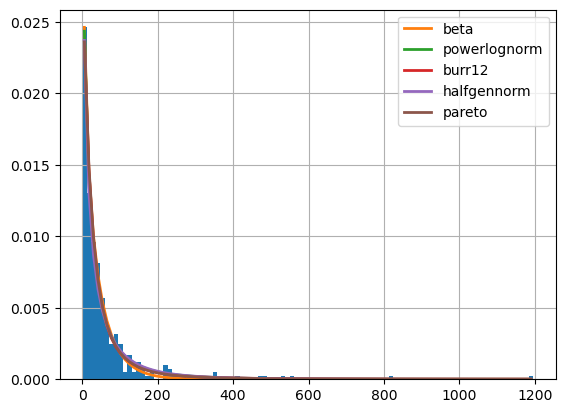

In [35]:
f = Fitter(scm_counts['count'].dropna())
f.fit()
f.summary()

SKIPPED _fit distribution (taking more than 30 seconds)
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = integrate.quad(llc, x0, x1,
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  intgrl = integrate.quad(llc, x0, x1,
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
f,0.000149,1691.298052,1699.741547,inf,0.135069,0.196960
erlang,0.000153,1941.984919,1948.317540,inf,0.196286,0.015560
chi2,0.000153,1703.090755,1709.423377,inf,0.085198,0.735448
chi,0.000153,1885.753696,1892.086318,inf,0.105557,0.473102
truncweibull_min,0.000154,1565.678801,1576.233171,inf,0.143862,0.145016


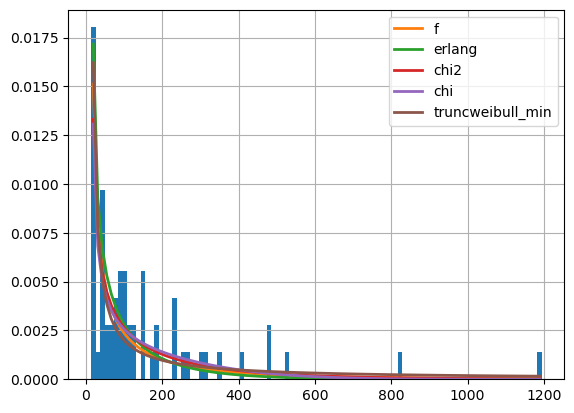

In [5]:
f = Fitter(scm_max_counts['count'].dropna())
f.fit()
f.summary()

### Climate

Merged dataframe for SCM counts and features. 

In [25]:
scm_model = pd.merge(scm_counts, weekly_climate, on=['record_id', 'week'], how = 'left')
scm_model = pd.merge(scm_model, soil_lab, on=['record_id'], how = 'left')
scm_model = pd.merge(scm_model, soil_map, on=['record_id'], how = 'left')

scm_model = scm_model.dropna()
scm_model.to_csv('Dataframes/scm_model.csv')
scm_model

,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,...,kffact,om,perm,thick,hygrp,drain,slope,ll,ifhydric,afldfreq
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,...,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,...,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,...,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,...,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,...,0.31,1.0,0.66,67.7,2.1,3.6,8.3,23.9,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,...,0.31,1.2,0.34,62.4,3.4,5.0,3.4,35.5,0.2,4.0
516,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,...,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
518,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,...,0.34,1.0,0.93,60.0,2.7,4.5,6.1,27.2,0.1,4.0
575,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,...,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4


In [26]:
scm_model_practices = pd.merge(scm_model, practices, on=['record_id'], how = 'left')
scm_model_practices['planting_relative_week'] = scm_model_practices['week'] - scm_model_practices['planting_week']

scm_model_practices.to_csv('Dataframes/scm_model_practices.csv')
scm_model_practices

,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,...,ll,ifhydric,afldfreq,latitude,longitude,cover_crop,manure,planting_date,planting_week,planting_relative_week
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,...,23.9,0.1,3.4,42.556020,-76.244470,No,No,NaT,NaN,NaN
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,...,23.9,0.1,3.4,42.634690,-76.128060,Yes,NaN,2022-05-13,20.0,-3.0
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,...,28.2,0.0,4.0,42.571300,-76.082880,Yes,NaN,2022-05-13,20.0,-3.0
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,...,28.2,0.0,4.0,42.515120,-76.162020,No,Yes,2022-05-13,20.0,-3.0
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,...,23.9,0.0,4.0,42.839830,-76.297810,No,Yes,2022-05-17,21.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,...,35.5,0.2,4.0,44.771089,-74.660663,NaN,NaN,NaT,NaN,NaN
312,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,...,23.9,0.1,3.4,43.003637,-75.590703,No,NaN,2022-06-28,27.0,-2.0
313,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,...,27.2,0.1,4.0,42.959892,-74.659539,Yes,Yes,2022-06-27,27.0,-2.0
314,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,...,23.9,0.1,3.4,43.003637,-75.590703,No,NaN,2022-06-28,27.0,-1.0


### 500m Radius

In [27]:
scm_500 = pd.merge(
    scm_model_practices,
    scm_cdl_500,
    on="record_id",
    how="left",
)
scm_500.to_csv('Dataframes/scm_500.csv')
scm_500


,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,...,334.0,0.244868,380.0,0.278592,79.0,0.057918,51.0,0.037390,0.0,0.000000
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,...,349.0,0.255490,247.0,0.180820,137.0,0.100293,77.0,0.056369,1.0,0.000732
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,...,263.0,0.192251,187.0,0.136696,304.0,0.222222,72.0,0.052632,1.0,0.000731
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,...,276.0,0.202050,145.0,0.106149,321.0,0.234993,57.0,0.041728,0.0,0.000000
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,...,576.0,0.421053,98.0,0.071637,72.0,0.052632,95.0,0.069444,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,...,684.0,0.500366,81.0,0.059254,18.0,0.013168,67.0,0.049012,0.0,0.000000
312,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,...,356.0,0.260806,230.0,0.168498,158.0,0.115751,61.0,0.044689,0.0,0.000000
313,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,...,224.0,0.163743,347.0,0.253655,68.0,0.049708,60.0,0.043860,0.0,0.000000
314,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,...,356.0,0.260806,230.0,0.168498,158.0,0.115751,61.0,0.044689,0.0,0.000000


### 1000m Radius

In [28]:
scm_1000 = pd.merge(
    scm_model,
    scm_cdl_1000,
    on="record_id",
    how="left",
)
scm_1000


,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,...,1052.0,0.235399,1555.0,0.347953,450.0,0.100694,293.0,0.065563,4.0,0.000895
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,...,984.0,0.220529,1334.0,0.298969,689.0,0.154415,265.0,0.059390,2.0,0.000448
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,...,1102.0,0.246698,1372.0,0.307141,581.0,0.130065,196.0,0.043877,1.0,0.000224
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,...,694.0,0.155501,995.0,0.222944,1281.0,0.287027,266.0,0.059601,1.0,0.000224
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,...,1809.0,0.404970,989.0,0.221401,273.0,0.061115,253.0,0.056638,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,...,1909.0,0.426878,894.0,0.199911,190.0,0.042487,418.0,0.093470,1.0,0.000224
312,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,...,1197.0,0.267905,1286.0,0.287825,548.0,0.122650,252.0,0.056401,0.0,0.000000
313,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,...,1261.0,0.282292,919.0,0.205731,401.0,0.089769,175.0,0.039176,0.0,0.000000
314,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,...,1197.0,0.267905,1286.0,0.287825,548.0,0.122650,252.0,0.056401,0.0,0.000000


### 2000m Radius

In [29]:
scm_2000 = pd.merge(
    scm_model,
    scm_cdl_2000,
    on="record_id",
    how="left",
)
scm_2000

,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,...,2502.0,0.157706,6518.0,0.410841,2996.0,0.188843,1362.0,0.085849,29.0,0.001828
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,...,2689.0,0.169450,6537.0,0.411935,2528.0,0.159304,1047.0,0.065978,24.0,0.001512
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,...,2042.0,0.128711,8735.0,0.550583,1821.0,0.114781,600.0,0.037819,3.0,0.000189
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,...,1612.0,0.101575,6817.0,0.429553,3416.0,0.215249,1161.0,0.073157,55.0,0.003466
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,...,4737.0,0.298525,5608.0,0.353416,1838.0,0.115831,1068.0,0.067305,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,...,5532.0,0.348472,5616.0,0.353764,1067.0,0.067213,971.0,0.061165,8.0,0.000504
312,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,...,3770.0,0.237540,4490.0,0.282906,3456.0,0.217756,1167.0,0.073530,9.0,0.000567
313,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,...,5476.0,0.344988,2448.0,0.154224,2123.0,0.133749,902.0,0.056826,218.0,0.013734
314,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,...,3770.0,0.237540,4490.0,0.282906,3456.0,0.217756,1167.0,0.073530,9.0,0.000567


In [32]:
scm_model_practices

,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,...,ll,ifhydric,afldfreq,latitude,longitude,cover_crop,manure,planting_date,planting_week,planting_relative_week
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,...,23.9,0.1,3.4,42.556020,-76.244470,No,No,NaT,NaN,NaN
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,...,23.9,0.1,3.4,42.634690,-76.128060,Yes,NaN,2022-05-13,20.0,-3.0
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,...,28.2,0.0,4.0,42.571300,-76.082880,Yes,NaN,2022-05-13,20.0,-3.0
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,...,28.2,0.0,4.0,42.515120,-76.162020,No,Yes,2022-05-13,20.0,-3.0
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,...,23.9,0.0,4.0,42.839830,-76.297810,No,Yes,2022-05-17,21.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,...,35.5,0.2,4.0,44.771089,-74.660663,NaN,NaN,NaT,NaN,NaN
312,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,...,23.9,0.1,3.4,43.003637,-75.590703,No,NaN,2022-06-28,27.0,-2.0
313,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,...,27.2,0.1,4.0,42.959892,-74.659539,Yes,Yes,2022-06-27,27.0,-2.0
314,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,...,23.9,0.1,3.4,43.003637,-75.590703,No,NaN,2022-06-28,27.0,-1.0


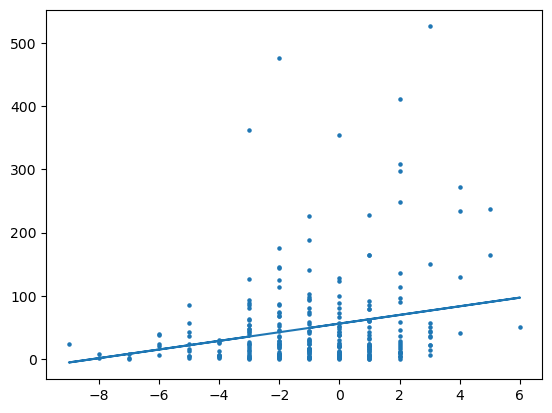

In [43]:
planting_dates = scm_model_practices.drop(['cover_crop', 'manure'], axis=1).dropna()
planting_dates.to_csv('Dataframes/planting_dates.csv')

a, b = np.polyfit(planting_dates['planting_relative_week'], planting_dates['count'], 1)

plt.scatter(planting_dates['planting_relative_week'], planting_dates['count'], s=5)
plt.plot(planting_dates['planting_relative_week'], a*planting_dates['planting_relative_week']+b)

In [40]:
before_planting = scm_model_practices.loc[scm_model_practices['planting_relative_week'] < 0]
after_planting = scm_model_practices.loc[scm_model_practices['planting_relative_week'] >= 0]


5.446066640876014
21.382524981720714


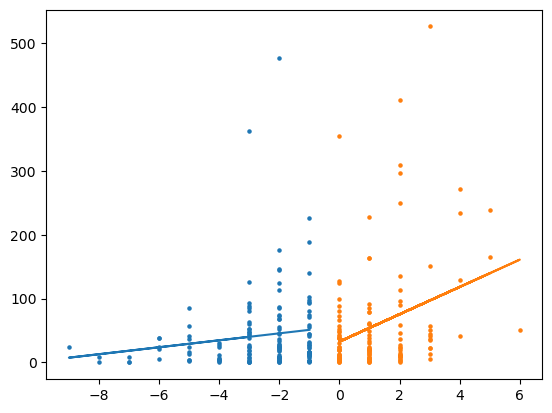

In [41]:
a, b = np.polyfit(before_planting['planting_relative_week'], before_planting['count'], 1)
print(a)
c, d = np.polyfit(after_planting['planting_relative_week'], after_planting['count'], 1)
print(c)

plt.scatter(before_planting['planting_relative_week'], before_planting['count'], s=5)
plt.plot(before_planting['planting_relative_week'], a*before_planting['planting_relative_week']+b)

plt.scatter(after_planting['planting_relative_week'], after_planting['count'], s=5)
plt.plot(after_planting['planting_relative_week'], c*after_planting['planting_relative_week']+d)


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='planting_relative_week', ylabel='count'>

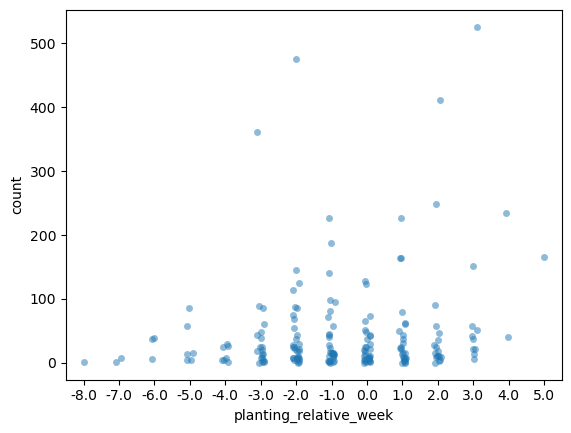

In [ ]:
sns.stripplot(y='count', x='planting_relative_week', data=scm_model_practices, alpha=0.5, jitter=True)